In [2]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt
%matplotlib inline

## Explicitly register date converters
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


In [3]:
csv_file = 'covis_db_metadata_report_20190403.csv'

data = pd.read_csv(csv_file)
data['datetime'] = pd.to_datetime(data['datetime'])
data.rename( columns={"# basename" : "basename"}, inplace=True )
print(data.columns)

Index(['basename', 'datetime', 'site', 'mode', 'raw_size', 'gz_size',
       '7z_size'],
      dtype='object')


In [4]:
raw_size = data['raw_size'].sum()

date_min = data['datetime'].min()
date_max = data['datetime'].max()
date_span = date_max - date_min



print("Total of %d data files spanning %d days from %s to %s" % (len(data.index), date_span.days, \
                                                                date_min.strftime('%Y-%m-%d'), \
                                                                 date_max.strftime('%Y-%m-%d')) )
print("Raw size % 9.2f GB  (%15d bytes)" % (raw_size / 1024**3, raw_size))

raw_null_files = data[ pd.isnull(data['raw_size']) ]
zip_null_files = data[ pd.isnull(data['7z_size']) ]
print("")
print("%d files with no reported raw size" % len(raw_null_files))
print("%d files with no reported 7z size" % len(zip_null_files))

# Count number with non-zero gz size
gz_files = data[ data['gz_size'] > 0 ]

gz_raw_size = gz_files['raw_size'].sum()
gz_size  = gz_files['gz_size'].sum()

print("")
print("%d files with reported .gz size (only files from Ashes which are posted to S3 bucket)" % len(gz_files))
print("gz size  % 9.2f GB  (%15d bytes) mean compression %.2f pct" % ( gz_size / 1024**3,  gz_size, 100*gz_size/gz_raw_size))

gz_mean_compression = gz_files['gz_size'].sum()/gz_files['raw_size'].sum() 
print("Mean gz compression: %.2f %%" % (gz_mean_compression*100))


zip_files = data[ data['7z_size'] > 0]
zip_size = zip_files['7z_size'].sum()
zip_raw_size = zip_files['raw_size'].sum()

print("")
print("%d files with reported .7z size" % len(zip_files))
print("7z size  % 9.2f GB  (%15d bytes) mean compression %.2f pct" % (zip_size / 1024**3, zip_size, 100*zip_size/zip_raw_size))


print("")
print("%d entries in database which aren't in the 7z archive:" % len(zip_null_files))
print(zip_null_files['basename'])

Total of 54805 data files spanning 3107 days from 2010-09-30 to 2019-04-03
Raw size  119597.81 GB  (128417169874498 bytes)

466 files with no reported raw size
14 files with no reported 7z size

7390 files with reported .gz size (only files from Ashes which are posted to S3 bucket)
gz size    1649.32 GB  (  1770944963473 bytes) mean compression 29.58 pct
Mean gz compression: 29.58 %

54791 files with reported .7z size
7z size   21072.46 GB  ( 22626380108407 bytes) mean compression 17.62 pct

14 entries in database which aren't in the 7z archive:
4405     APLUWCOVISMBSONAR001_20111002T001157.593Z-DOPPLER
4406     APLUWCOVISMBSONAR001_20111003T001156.606Z-DOPPLER
4407     APLUWCOVISMBSONAR001_20111003T061155.528Z-DOPPLER
4408     APLUWCOVISMBSONAR001_20111004T003551.745Z-DOPPLER
4409     APLUWCOVISMBSONAR001_20111004T063549.504Z-DOPPLER
4410     APLUWCOVISMBSONAR001_20111005T001156.667Z-DOPPLER
4411     APLUWCOVISMBSONAR001_20111005T061159.035Z-DOPPLER
18792    APLUWCOVISMBSONAR001_20130

In [5]:
## Estimate gz sizes for Endeavour


data['gz_size'] = data.apply(
    lambda row: row['raw_size']*gz_mean_compression if np.isnan(row['gz_size']) else row['gz_size'],
    axis=1
)


In [6]:
ashes = data[ data['site'] =='Ashes' ]
endeavour = data[ data['site'] == 'Endeavour']

print("Of those, %d are from Ashes, %d from Endeavor" % (len(ashes), len(endeavour)))
print("Ashes raw size of %.2f TB" % (ashes['raw_size'].sum() / 1024**4))
print("Ashes gz  size of %.2f TB" % (ashes['gz_size'].sum() / 1024**4))
print("Ashes 7z  size of %.2f TB" % (ashes['7z_size'].sum() / 1024**4))

print("Endeavour raw size of %.2f TB" % (endeavour['raw_size'].sum() / 1024**4))
print("Endeavour gz  size of %.2f TB" % (endeavour['gz_size'].sum() / 1024**4))
print("Endeavour 7z  size of %.2f TB" % (endeavour['7z_size'].sum() / 1024**4))

Of those, 7390 are from Ashes, 47415 from Endeavor
Ashes raw size of 5.45 TB
Ashes gz  size of 1.61 TB
Ashes 7z  size of 1.00 TB
Endeavour raw size of 111.35 TB
Endeavour gz  size of 32.93 TB
Endeavour 7z  size of 19.58 TB


In [7]:
##  Create a "simplified mode" column

squash = { 'diffuse': re.compile('diffuse*', flags=re.IGNORECASE),
            'doppler': re.compile('doppler*', flags=re.IGNORECASE),
             'imaging': re.compile('imag*', flags=re.IGNORECASE),
             'bathy':  re.compile('bathy*', flags=re.IGNORECASE),
             'survey':  re.compile('survey*', flags=re.IGNORECASE),
             'pano': re.compile('pano*', flags=re.IGNORECASE)}

def simplify_mode(mode):
    for key,regex in squash.items():
        if regex.match(mode):
            return key

    return mode

data['simple_mode'] = data.apply(lambda row: simplify_mode( row['mode'] ), axis=1 )

print("Simplified modes: %s" % data.simple_mode.unique())

Simplified modes: ['survey' 'imaging' 'diffuse' 'target' 'doppler' 'bathy' 'pano']


In [8]:
dates = {}
types = {}

for index, entry in data.iterrows():
    dates[ entry['datetime'].date() ] = True
        
    if entry.simple_mode not in types:
        types[entry.simple_mode] = 0
        
    types[entry.simple_mode] += 1
    
print("COVIS ran on %d days, averaging %.2f GB per day (as gz)" % (len(dates), (gz_size / (1024**3*len(dates)))))
    
for mode,count in types.items():
    print("%10s : %d" % (mode,count))
    

COVIS ran on 1555 days, averaging 1.06 GB per day (as gz)
    survey : 3
   imaging : 11733
   diffuse : 33045
    target : 18
   doppler : 9984
     bathy : 3
      pano : 19


In [9]:
types = {}
for index, entry in data.iterrows():
    if entry['mode'] not in types:
        types[entry['mode']] = 0
        
    types[entry['mode']] += 1
    
for mode,count in types.items():
    print("%10s : %d" % (mode,count))

   survey1 : 1
   survey2 : 1
   imaging : 1
   diffuse : 9
   survey3 : 1
  diffuse3 : 479
  diffuse2 : 515
  diffuse1 : 480
    target : 18
  imaging1 : 177
  imaging2 : 180
  imaging3 : 184
  doppler1 : 1
  doppler2 : 97
  doppler3 : 1
diffuse2up : 1
diffuse2down : 3
diffuse3down : 1
diffuse1down : 1
    bathy2 : 1
    bathy1 : 1
    bathy3 : 1
diffuse3deep : 213
diffuse1deep : 206
diffuse2deep : 217
diffuse2shallow : 219
diffuse1shallow : 214
diffuse3shallow : 216
   IMAGING : 10185
   DOPPLER : 9885
   DIFFUSE : 27320
DIFFUSESLOW : 25
  panoleft : 8
panocenter : 7
 panoright : 2
diffuseright : 1473
diffuseleft : 1453
 panoleft2 : 1
panoright2 : 1
 imageleft : 503
imagecenter : 503


In [10]:
## Calculate mean counts and size per day

by_date = data.set_index('datetime')
by_date.sort_index(inplace=True)
by_day = by_date.resample('D').sum()
by_day['count'] = by_date.basename.resample('D').count()
by_day = by_day[ by_day['count'] > 0 ]

## by_day is now the _total_ amount of data produced per day

## by_month is the _mean daily_ data
by_month = by_day.resample('M').mean()


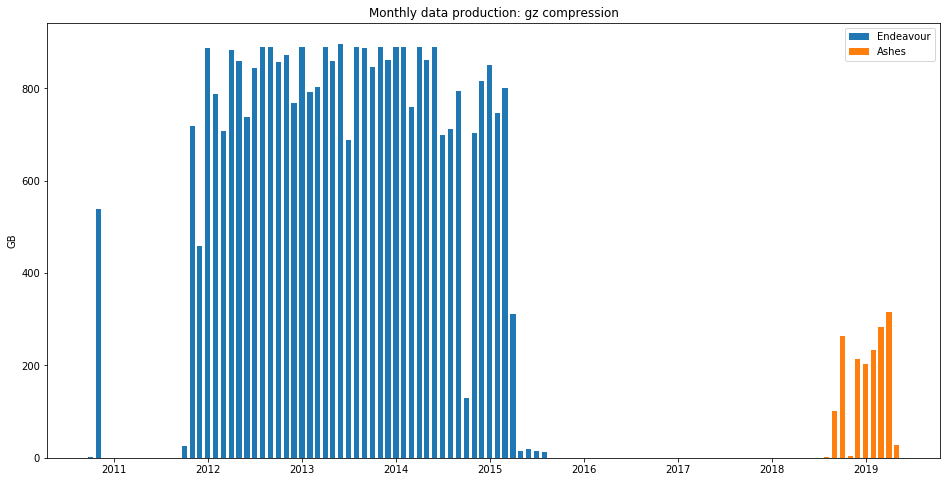

In [11]:
plt.figure( figsize=(16,8))
yscalar = 1.0 / 1024**3

d = by_date.resample('M').sum()
#plt.bar( d.index, d.raw_size * yscalar, width=20, label='raw' )

ed = d["2001-01-01":"2018-01-01"]
plt.bar( ed.index, ed.gz_size * yscalar, width=20, label='Endeavour' )

ad = d["2018-01-01":'2025-01-01']
plt.bar( ad.index, ad.gz_size * yscalar, width=20, label='Ashes' )



#plt.bar( by_month.index, by_month.estimated_gz_size * yscalar, width=20, label='est. gz' )
#plt.bar( by_month.index, by_month['7z_size'] * yscalar, width=20, label='7z' )

plt.title('Monthly data production: gz compression')
plt.ylabel('GB')
plt.legend()

plt.show()

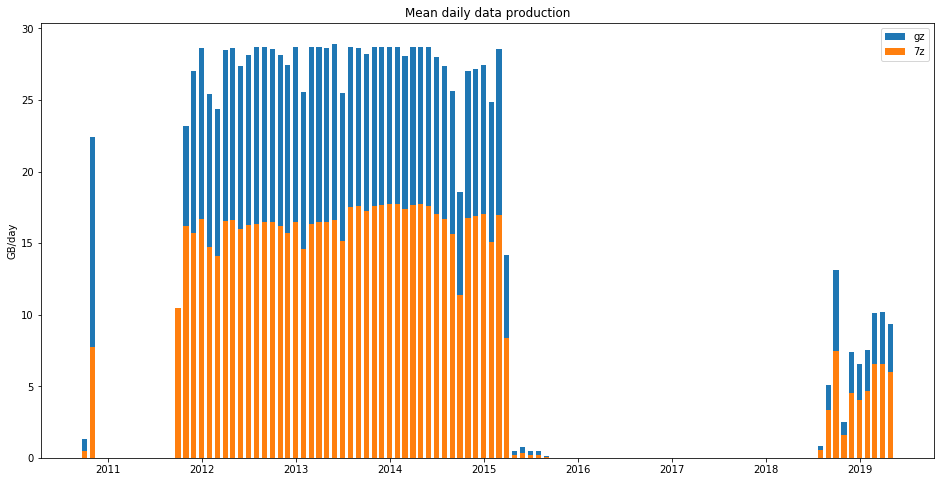

In [12]:
plt.figure( figsize=(16,8))
yscalar = 1.0 / 1024**3
plt.bar( by_month.index, by_month.gz_size * yscalar, width=20, label='gz' )
#plt.bar( by_month.index, by_month.estimated_gz_size * yscalar, width=20, label='est. gz' )
plt.bar( by_month.index, by_month['7z_size'] * yscalar, width=20, label='7z' )


plt.title('Mean daily data production')
plt.ylabel('GB/day')
plt.legend()

plt.show()

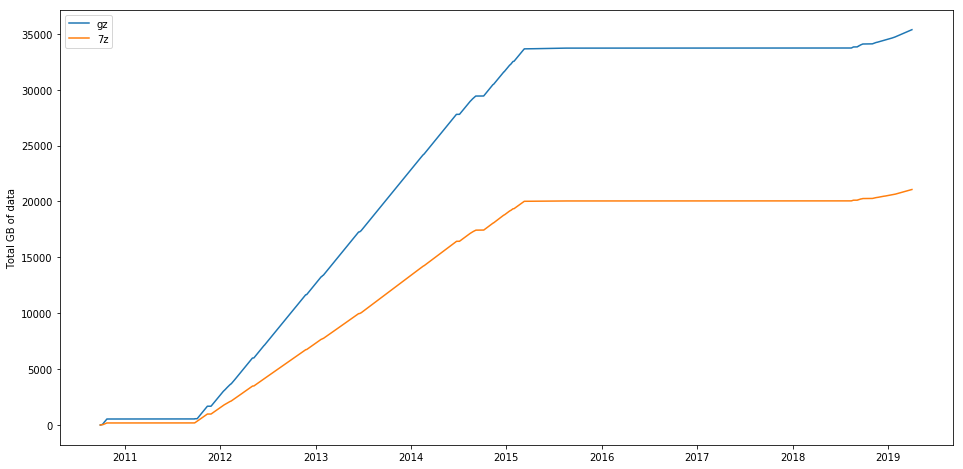

In [13]:

#by_day['gz_total'] = by_day['gz_size'] + by_day['estimated_gz_size']

by_day['raw_accumulated'] = by_day['raw_size'].cumsum()
by_day['gz_accumulated'] = by_day['gz_size'].cumsum()
by_day['7z_accumulated'] = by_day['7z_size'].cumsum()


plt.figure( figsize=(16,8) )
plt.plot( by_day.index, by_day.gz_accumulated * yscalar, label='gz' )
plt.plot( by_day.index, by_day['7z_accumulated'] * yscalar , label='7z' )

plt.ylabel('Total GB of data')
plt.legend()
plt.show()

# print(by_day)


In [32]:
## Calculate accumulation by simplified type

by_date = data.set_index('datetime')
by_date.sort_index(inplace=True)
# by_day = by_date.resample('D').sum()
# by_day['count'] = by_date.basename.resample('D').count()
# by_day = by_day[ by_day['count'] > 0 ]

# print(by_day)

## by_day is now the _total_ amount of data produced per day
## by_month is the _mean daily_ data
# by_month = by_day.resample('M').mean()
gz_per_day = pd.DataFrame( index=by_date.resample('D').sum().index )
gz_per_month = pd.DataFrame( index=by_date.resample('M').sum().index )

zip_per_month = pd.DataFrame( index=by_date.resample('M').sum().index )

count_per_day = pd.DataFrame( index=gz_per_day.index )
count_per_month = pd.DataFrame( index=gz_per_month.index )

for mode in data.simple_mode.unique():
    per_day = by_date[ by_date.simple_mode == mode ]['gz_size'].resample('D')
    #per_day.replace(0, np.NaN, inplace=True)
    
    gz_per_day[mode] = per_day.sum()
    count_per_day[mode] = per_day.count()
    
    
    per_month = by_date[ by_date.simple_mode == mode ]['gz_size'].resample('M')
    #per_month.replace(0, np.NaN, inplace=True)
    
    gz_per_month[mode] = per_month.sum()
    zip_per_month[mode] = by_date[ by_date.simple_mode == mode ]['7z_size'].resample('M').sum() / 1024**3
    
    count_per_month[mode] = per_month.count()
    
gz_per_day = gz_per_day.resample('M').mean()
count_per_day = count_per_day.resample('M').mean()
        
gz_per_day = gz_per_day / 1024**3   
gz_per_month = gz_per_month / 1024**3



            survey  imaging  diffuse  target  doppler  bathy  pano
datetime                                                          
2018-07-31     3.0      4.0      142     6.0      3.0    NaN   NaN
2018-08-31     NaN    259.0     2091    12.0      2.0    3.0   NaN
2018-09-30     NaN    279.0      541     NaN     94.0    NaN   NaN
2018-10-31     NaN      0.0        2     NaN      NaN    NaN   9.0
2018-11-30     NaN    324.0      240     NaN      NaN    NaN  10.0
2018-12-31     NaN    370.0      280     NaN      NaN    NaN   NaN
2019-01-31     NaN    312.0      428     NaN      NaN    NaN   NaN
2019-02-28     NaN      NaN      896     NaN      NaN    NaN   NaN
2019-03-31     NaN      NaN      992     NaN      NaN    NaN   NaN
2019-04-30     NaN      NaN       88     NaN      NaN    NaN   NaN
              survey     imaging     diffuse    target     doppler     bathy  \
datetime                                                                       
2018-07-31  0.080536    1.447619    

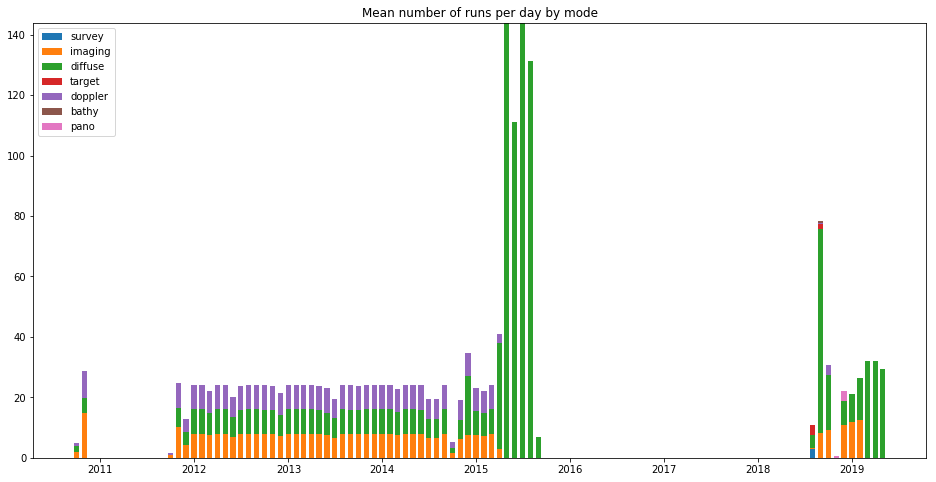

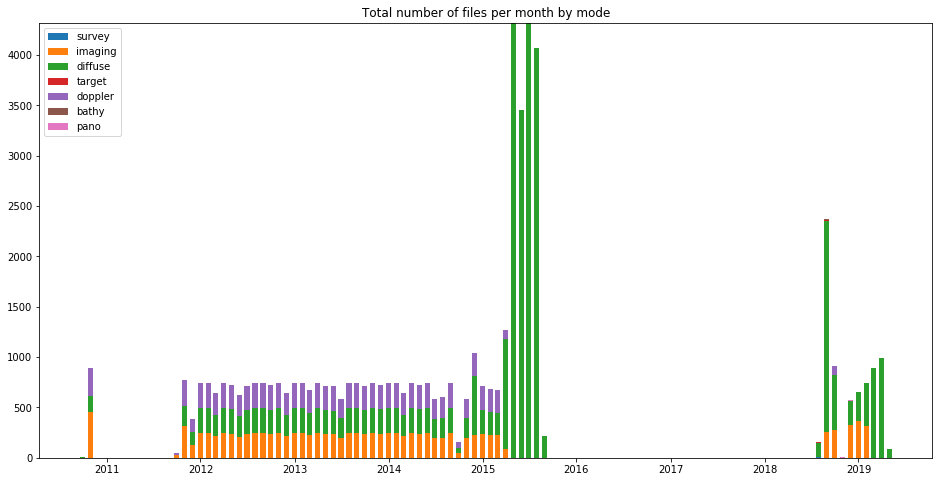

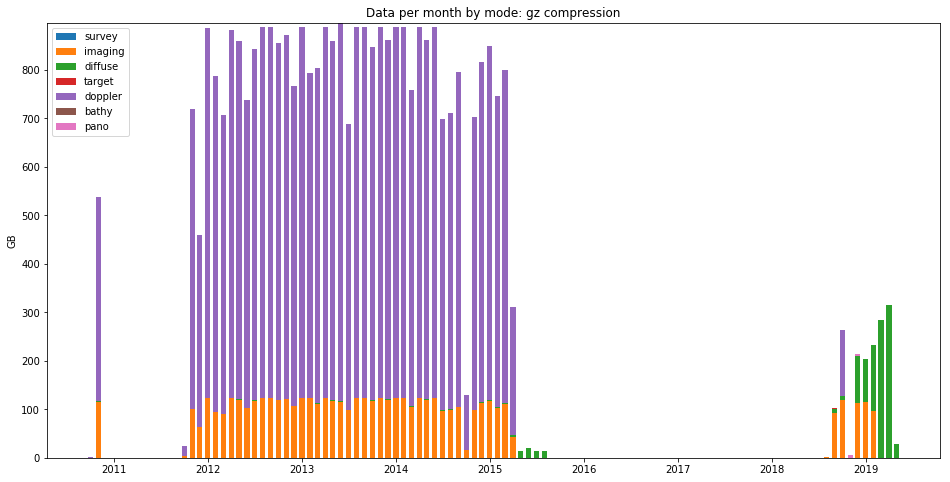

In [15]:

def stacked_mode_bars(df):
    fig,ax = plt.subplots()
    fig.set_size_inches(16,8)
    
    prev=pd.Series(0, index=df.index)

    for mode in data.simple_mode.unique():
        ax.bar(df.index, height=df[mode], bottom=prev, width=20, label=mode)
        prev = prev.add( df[mode], fill_value=0)    

    return fig,ax

stacked_mode_bars(count_per_day)

plt.legend()
plt.title('Mean number of runs per day by mode')
plt.ylabel("")
plt.show()

##


fig,ax = stacked_mode_bars( count_per_month )

plt.legend()
plt.title("Total number of files per month by mode")
plt.show()


##

fig,ax = stacked_mode_bars(gz_per_month)   
    
plt.legend()
plt.title("Data per month by mode: gz compression")
plt.ylabel("GB")
plt.show()




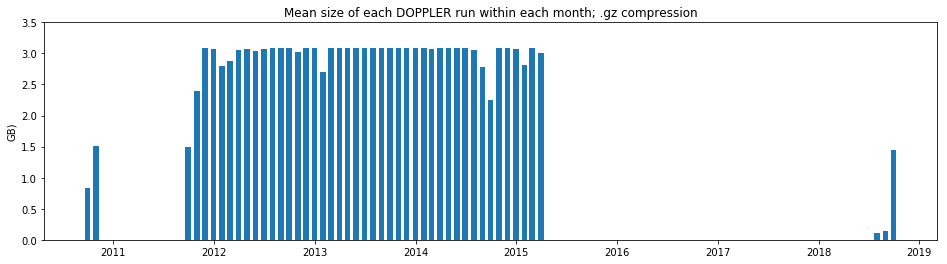

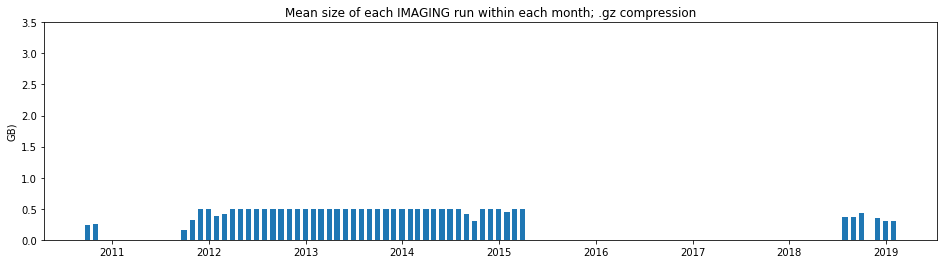

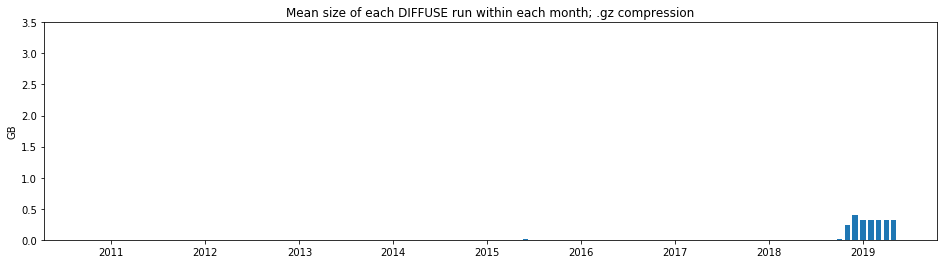

In [20]:
## Mean data sizes

mean_size_per_month = gz_per_month / count_per_month
zip_size_per_month = zip_per_month / count_per_month



def plot_mean_size(data,mode):
    
    fig,ax = plt.subplots()
    fig.set_size_inches(16,4)

    ax.bar(data.index, height=data[mode], width=20, label=mode)
    plt.ylim(0.0,3.5)

    return fig,ax

plot_mean_size(mean_size_per_month, 'doppler')
plt.title("Mean size of each DOPPLER run within each month; .gz compression")
plt.ylabel("GB)")
plt.show()

##

plot_mean_size(mean_size_per_month, 'imaging')
plt.title("Mean size of each IMAGING run within each month; .gz compression")
plt.ylabel("GB)")
plt.show()

plot_mean_size(mean_size_per_month, 'diffuse')
plt.title("Mean size of each DIFFUSE run within each month; .gz compression")
plt.ylabel("GB")
plt.show()



In [29]:
(mean_size_per_month*1024).tail(10).to_csv("ashes_mean_data_sizes_mb.csv", float_format="%.2f")